In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import glam

%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Set up sensible parameter bounds first. These are based on the parameter estimates obtained fitting the model to the Krajbich & Rangel (2011) ternary choice data set.

In [2]:
parameter_bounds = dict(v=(0.00003, 0.00015),
                        s=(0.005, 0.011),
                        gamma=(-1, 1),
                        tau=(0.2, 2))

# Testing the `GLAM.predict` method

## Simulation

We simulate two groups with different gaze biases (`gamma` parameters). Note, this is a between-subject design. The two groups are of different sizes. Here, we simulate from individual parameters, but this should not matter.

In [3]:
np.random.seed(1)

m = glam.GLAM()

n_items = 3
n_trials = 100

groups = ['A', 'B']
n_groups = len(groups)
N = dict(A=10, B=15)

gamma_mu = dict(A=0.5, B=-0.5)
gamma_sd = dict(A=0.2, B=0.2)

for group in groups:

    parameters = dict(v=np.clip(np.random.normal(loc=0.00007,
                                                 scale=0.00001,
                                                 size=N[group]),
                                *parameter_bounds['v']),
                      gamma=np.clip(np.random.normal(loc=gamma_mu[group],
                                                     scale=gamma_sd[group],
                                                     size=N[group]), 
                                    *parameter_bounds['gamma']),
                      s=np.clip(np.random.normal(loc=0.008,
                                                 scale=0.001,
                                                 size=N[group]),
                                *parameter_bounds['s']),
                      tau=np.clip(np.random.normal(loc=0.8,
                                                   scale=0.1,
                                                   size=N[group]),
                                  *parameter_bounds['tau']),
                      t0=np.zeros(N[group]))
    
    m.simulate_group(kind='individual',
                     parameters=parameters,
                     n_individuals=N[group],
                     n_trials=n_trials,
                     n_items=n_items,
                     label=group)

m.data.rename({'condition':'group'}, axis=1, inplace=True)

In [4]:
def plot_model_parameters(model, parameters=['v', 'gamma', 's', 'tau'],
                          parameter_bounds=dict(v=(0.00003, 0.00015),
                                                s=(0.005, 0.011),
                                                gamma=(-1, 1),
                                                tau=(0.2, 2)),
                          n_bins=10):

    fig, axs = plt.subplots(1, len(parameters),
                            figsize=(len(parameters)*3, 3),
                            sharey='row')

    for g, group in enumerate(model.parameters.keys()):
        for p, parameter in enumerate(parameters):
            axs[p].hist(model.parameters[group][parameter],
                        bins=np.linspace(*parameter_bounds[parameter], n_bins),
                        color='C{}'.format(g),
                        alpha=0.75,
                        label=group)
            axs[p].set_title(parameter)
    axs[-1].legend()
    fig.tight_layout()
    
    return fig, axs

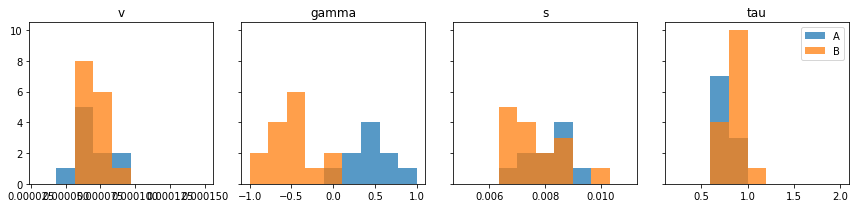

In [5]:
plot_model_parameters(m);

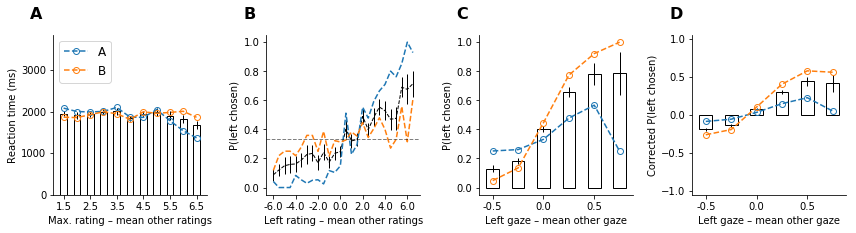

In [6]:
glam.plot_fit(m.data,
              [m.data[m.data['group'] == group]
               for group in groups],
              prediction_labels=groups);

## Model fitting

In [ ]:
m.make_model('hierarchical',
             depends_on=dict(gamma='group'),
             t0_val=0)
m.fit(method='NUTS', njobs=1)

Generating hierarchical model for 25 subjects...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Fitting 1 model(s) using NUTS...
  Fitting model 1 of 1...


/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [tau_interval__, tau_sd_interval__, tau_mu_interval__, s_interval__, s_sd_interval__, s_mu_interval__, gamma_B_interval__, gamma_A_interval__, gamma_B_sd_interval__, gamma_A_sd_interval__, gamma_B_mu_interval__, gamma_A_mu_interval__, v_interval__, v_sd_interval__, v_mu_interval__]
 73%|███████▎  | 1835/2500 [13:50:32<5:00:59, 27.16s/it] 

In [ ]:
from pymc3 import traceplot, summary

traceplot(m.trace);

In [ ]:
summary(m.trace).loc[['v_mu', 'gamma_A_mu', 'gamma_B_mu', 's_mu', 'tau_mu']]

In [ ]:
m.estimates['gamma_A'].size

In [ ]:
m.estimates['gamma_B'].size